# Object Detection with TensorFlow and SSD MobileNet

This notebook demonstrates how to perform **object detection** using a pre-trained **Single Shot Multibox Detector (SSD)** with a **MobileNet** backbone.  
We use a model trained in **TensorFlow** from the TensorFlow Object Detection Model Zoo.

---

### Why SSD with MobileNet?

The model used — `ssd_mobilenet_v2_coco_2018_03_29` — is a lightweight deep learning object detector optimized for real-time performance on resource-constrained devices.

- **MobileNet** is a highly efficient Convolutional Neural Network (CNN) designed for mobile and embedded vision applications.
- The **SSD head** allows for multiple object detections at different scales from a single forward pass of the image.
- The combined architecture achieves a balance between **speed and accuracy**, making it ideal for real-time use cases such as live webcam feeds or embedded systems.

---

### Model Files

- `frozen_inference_graph.pb`: A frozen TensorFlow graph that contains the model’s architecture and trained weights.
- `pipeline.config`: The configuration used during training (useful for fine-tuning or model inspection).
- `saved_model/`: Directory containing the SavedModel format for use with TensorFlow 2.x or TensorFlow Lite.
- `checkpoint/`: Contains training checkpoints (not used for inference).


## Step 1: Import Libraries

- `os`: Provides access to file and directory handling, useful for navigating file paths and managing local directories.
- `cv2`: The OpenCV library, used for image loading, processing, and running deep learning inference using models like SSD or Haar cascades.
- `numpy`: A numerical computing library that supports efficient array operations, commonly used for image matrix manipulation.
- `urllib`: A built-in library for downloading data from the internet, such as pretrained models or sample images.
- `matplotlib.pyplot`: Used for displaying images and visualizations inline within the Jupyter Notebook (instead of using OpenCV's external GUI windows).
- `%matplotlib inline`: A Jupyter Notebook magic command that ensures all plots appear inside the notebook immediately after a plotting command.


In [1]:
import os
import cv2
import numpy as np
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Download and Extract the SSD MobileNet Model

In this step, we:

- Define paths to the model, configuration, and class label files.
- Check if the `models/` directory exists; if not, we create it.
- Check if the model file `frozen_inference_graph.pb` exists. If it doesn't:
  - We download the SSD MobileNet V2 model archive from the TensorFlow Model Zoo.
  - Extract the contents of the `.tar.gz` file into the `models/` directory.
  - Delete the compressed file after extraction to save space.

This setup ensures that the model files are automatically downloaded and ready to use when running the notebook for the first time.


In [2]:
modelFile = "models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
configFile = "models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt"
classFile = "coco_class_labels.txt"

if not os.path.isdir('models'):
    os.mkdir("models")

if not os.path.isfile(modelFile):
    os.chdir("models")
    # Download the tensorflow Model
    urllib.request.urlretrieve('http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz', 'ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Uncompress the file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Delete the tar.gz file
    os.remove('ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Come back to the previous directory
    os.chdir("..")

## Step 3: Load COCO Class Labels

- We open the file `coco_class_labels.txt`, which contains the list of class labels used in the COCO dataset (e.g., person, car, dog, etc.).
- Each line in the file corresponds to one class label.
- We read all the lines, split them by newline characters, and store the resulting list in a variable called `labels`.
- Finally, we print the list to verify that the class names were loaded correctly.

This list will later be used to assign readable labels to the detected objects.


In [3]:
with open(classFile) as fp:
    labels = fp.read().split("\n")
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


**The steps for performing infernece using a DNN model are summarized below:**
    
1. Load the model and input image into memory.
2. Detect objects using a forward pass through the network.
3. Display the detected objects with bounding boxes and class labels.

## Step 4: Load the TensorFlow Object Detection Model

- We use OpenCV’s `cv2.dnn.readNetFromTensorflow()` function to load the pre-trained SSD MobileNet model.
- `modelFile` refers to the frozen graph (`frozen_inference_graph.pb`) containing the model weights.
- `configFile` is the `.pbtxt` file that defines the model architecture and layer configuration.

This function loads the deep learning model into memory, preparing it for inference.


In [4]:
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

## Step 5: Define Object Detection Function

We define a function `detect_objects()` that performs object detection on a given image using the loaded SSD MobileNet model.

- `net`: The pre-loaded deep learning model (from OpenCV DNN).
- `im`: The input image on which detection will be performed.
- `dim = 300`: The input size expected by the model (300x300 pixels).

### What the function does:
1. **Create a blob** from the input image using `cv2.dnn.blobFromImage()`:
   - Resizes the image to `300x300`
   - Normalizes the pixel values
   - Swaps color channels from BGR to RGB
   - Converts the image into a 4D tensor (blob)

2. **Set the input** to the network using `net.setInput(blob)`.

3. **Run a forward pass** through the network using `net.forward()`, which returns detected objects along with their scores and bounding boxes.

4. **Return** the `objects` output, which will be processed in the next steps to extract and visualize detections.


In [5]:
# For ach file in the directory
def detect_objects(net, im):
    dim = 300
    
    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0,0,0), swapRB=True, crop=False)

    # Pass blob to the network
    net.setInput(blob)
    
    # Peform Prediction
    objects = net.forward()
    return objects


## Step 6: Define a Function to Display Labels on the Image

The `display_text()` function is used to draw readable labels (e.g., class name or confidence score) on the output image near the detected object.

### Parameters:
- `im`: The input image (to be annotated).
- `text`: The string to be displayed (e.g., class label or score).
- `x`, `y`: Coordinates for positioning the text on the image.

### How it works:
1. **Measure text size** using `cv2.getTextSize()` to calculate the width, height, and baseline of the text based on:
   - Font type (`FONTFACE`)
   - Font scale (`FONT_SCALE`)
   - Thickness (`THICKNESS`)

2. **Draw a filled black rectangle** slightly larger than the text to ensure the label is visible regardless of the background.

3. **Overlay the text** using `cv2.putText()` in a yellow color `(0, 255, 255)` for good visibility, with anti-aliasing for smoother rendering.

This function ensures clean and readable label annotations on detected objects.


In [6]:
def display_text(im, text, x, y):
    
    # Get text size 
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
            
    # Use text size to create a black rectangle    
    cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle
    cv2.putText(im, text, (x, y-5 ), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)


## Step 7: Define Function to Display Detected Objects

This function, `display_objects()`, takes the detection output from the model and overlays the bounding boxes and class labels on the original image.

### Constants:
- `FONTFACE`: Specifies the font used for text display (`cv2.FONT_HERSHEY_SIMPLEX`).
- `FONT_SCALE`: Controls the size of the text.
- `THICKNESS`: Controls the thickness of the text stroke.

### Parameters:
- `im`: The original input image.
- `objects`: The output from the SSD model's `forward()` pass.
- `threshold`: Minimum confidence score to consider a detection valid (default: 0.25).

### What the function does:
1. **Iterates over each detected object** in the `objects` array.
2. Extracts:
   - `classId`: The predicted class label index.
   - `score`: The confidence score.
   - Bounding box coordinates: Converted from normalized (0–1) format to actual image pixel coordinates.
3. **Applies a confidence threshold** to filter out weak detections.
4. If detection is valid:
   - Calls `display_text()` to draw the class label near the object.
   - Draws a white rectangle around the detected object using `cv2.rectangle()`.
5. Converts the final image from BGR to RGB (since OpenCV uses BGR but Matplotlib expects RGB).
6. Displays the result using Matplotlib with a large figure size.

This function provides a clean, visual summary of all objects detected in the image.


In [7]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_objects(im, objects, threshold = 0.25):

    rows = im.shape[0]; cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence 
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])
        
        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)
        
        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,10)); plt.imshow(mp_img); plt.show();

## Step 8: Run Detection on an Input Image

In this step, we perform object detection on a sample image using the previously defined functions.

### What happens:
1. `cv2.imread('images/DSC_0222.JPG')`  
   Loads the input image from the `images/` directory. You can replace the filename with any image you want to test.

2. `detect_objects(net, im)`  
   Passes the image to the SSD MobileNet model to get a list of detected objects and their associated scores and bounding boxes.

3. `display_objects(im, objects)`  
   Draws bounding boxes and class labels on the image, then displays the annotated image inline using Matplotlib.

This completes the end-to-end workflow for deep learning-based object detection using OpenCV DNN and a T


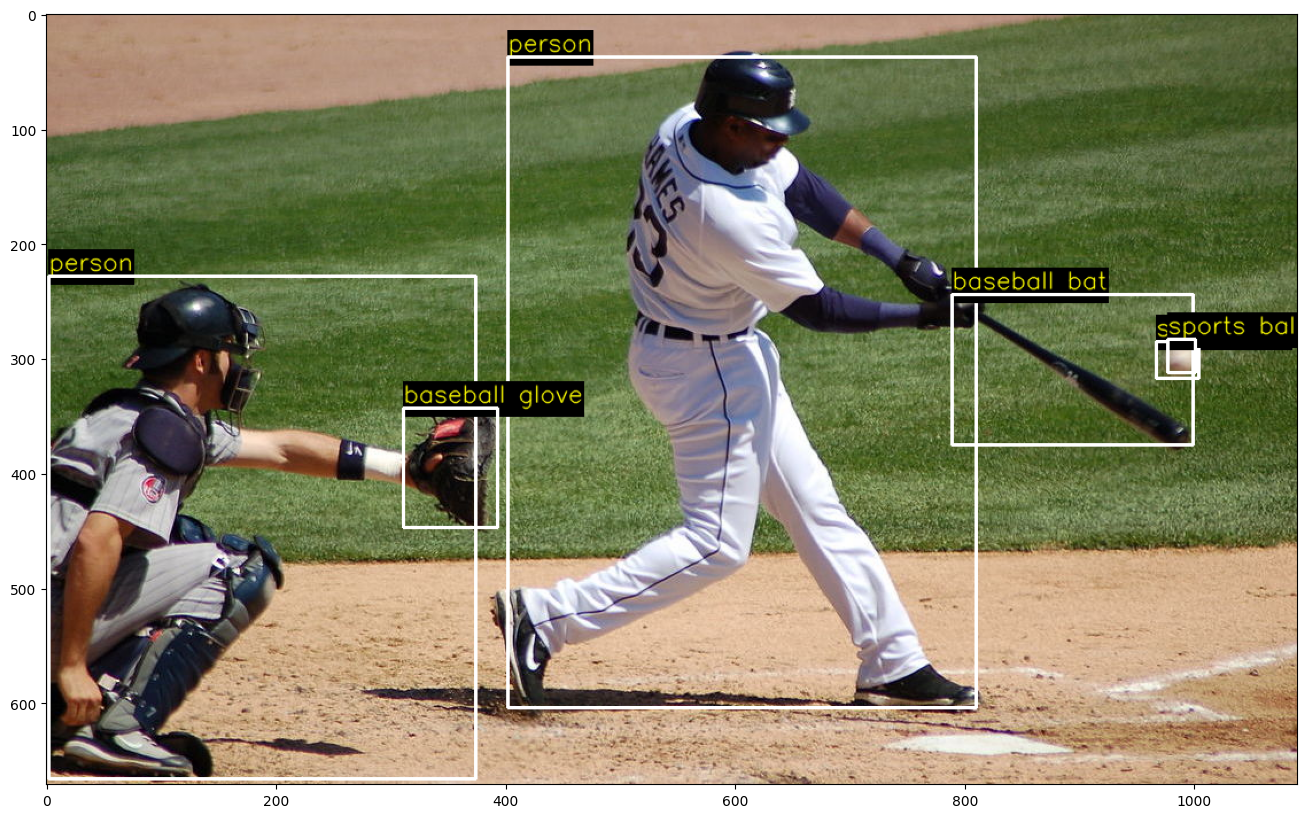

In [8]:
im = cv2.imread('images/baseball.jpg')
objects = detect_objects(net, im)
display_objects(im, objects, 0.2)

# !!Tips!!
# Download Model files from Tensorflow model ZOO

Model files can be downloaded from the Tensorflow Object Detection Model Zoo
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

**The cell given below downloads a mobilenet model**

## Download mobilenet model file
The code below will run on Linux / MacOS systems.
Please download the file http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

Uncompress it and put it in models folder.

**ssd_mobilenet_v2_coco_2018_03_29** <br>
|─ checkpoint <br>
|─ **frozen_inference_graph.pb** <br>
|─ model.ckpt.data-00000-of-00001 <br>
|─ model.ckpt.index <br>
|─ model.ckpt.meta <br>
|─ pipeline.config <br>
|─ saved_model <br>
|─── saved_model.pb <br>
|─── variables <br>